# Quantum Evolution Kernal for Earth Observation
This notebook uses `myqlm` as a backend for running the qek simulations. 
It is intended for running the `myqlm` workflow remotely.

In [1]:
import qsvm4eo
import numpy as np
import matplotlib.pyplot as plt
from qlmaas.qpus import AnalogQPU
from qat.core import Batch, Schedule

In [2]:
# Load the data
num_features = 4
x_train, y_train, x_test, y_test = qsvm4eo.load_data(
    data_path="..", num_features=num_features, scale_features=False
)

# Encode the data, transforming the features into qubit coordinates
encoding = qsvm4eo.RadialEncoding(
    max_feature=np.max(x_train), shift=1.0, scaling=5.4, n_features=num_features
)
qbits_train = [encoding.encode(x) for x in x_train]

print("Qubit Geometries:")
print(qbits_train[:4])

Qubit Geometries:
[array([[ 6.49087678e+00,  0.00000000e+00],
       [ 4.35649236e-16,  7.11469194e+00],
       [-7.33116114e+00,  8.97808302e-16],
       [-1.63603526e-15, -8.90616114e+00]]), array([[ 6.27760664e+00,  0.00000000e+00],
       [ 4.00259265e-16,  6.53672986e+00],
       [-7.04004739e+00,  8.62157151e-16],
       [-1.63152989e-15, -8.88163507e+00]]), array([[ 6.35225118e+00,  0.00000000e+00],
       [ 4.10380013e-16,  6.70201422e+00],
       [-7.04004739e+00,  8.62157151e-16],
       [-1.63152989e-15, -8.88163507e+00]]), array([[ 6.30959716e+00,  0.00000000e+00],
       [ 4.07898797e-16,  6.66149289e+00],
       [-7.11895735e+00,  8.71820833e-16],
       [-1.61409609e-15, -8.78672986e+00]])]


In [3]:
my_qpu = AnalogQPU()

# Create jobs
schedules = [
    Schedule(drive=qsvm4eo.generate_myqlm_hamiltonian(qbits), tmax=0.66)  # μs
    for qbits in qbits_train[:4]
]
jobs = [schedule.to_job() for schedule in schedules]

# Run jobs
async_result = my_qpu.submit(Batch(jobs))
results = async_result.join()

# Get state probabilities
probs = np.array([[r.probability for r in result] for result in results])
probs

Submitted a new batch: SJob50686


array([[0.00903964, 0.02251945, 0.01911961, 0.05280784, 0.01300843,
        0.03087011, 0.03574717, 0.09840438, 0.01490733, 0.04330092,
        0.03032208, 0.10172005, 0.03187283, 0.09379697, 0.09226106,
        0.31027468],
       [0.01434699, 0.0350623 , 0.02623184, 0.07207042, 0.01342478,
        0.02945027, 0.03462336, 0.09173703, 0.0190019 , 0.05444333,
        0.03032051, 0.10258453, 0.02937309, 0.08431295, 0.08182638,
        0.28116397],
       [0.01269288, 0.03103573, 0.0236488 , 0.06497668, 0.01343701,
        0.02996407, 0.03488439, 0.09348867, 0.01809655, 0.05172266,
        0.03025666, 0.10214412, 0.03055797, 0.08766355, 0.08509216,
        0.29031129],
       [0.01313069, 0.03165296, 0.02476304, 0.0671827 , 0.01369631,
        0.02991116, 0.03563597, 0.09372683, 0.01794235, 0.05106153,
        0.03016854, 0.10174862, 0.03026943, 0.08661307, 0.08435471,
        0.28811538]])

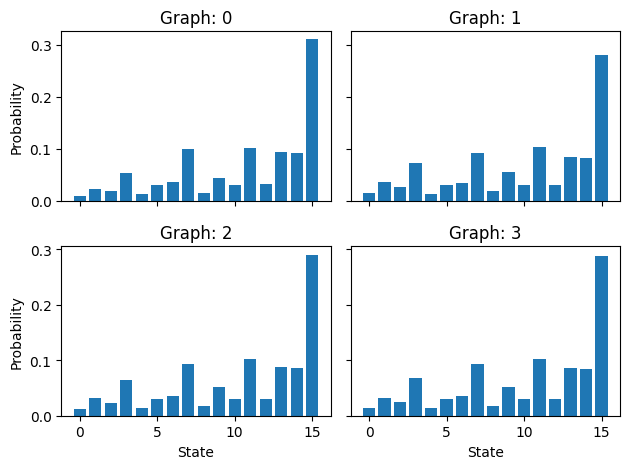

In [5]:
# Plot the probability of the states being measured
fig, axs = plt.subplots(nrows=2, ncols=2, sharex="col", sharey="row")

for c in range(4):
    axs[c // 2, c % 2].bar(range(num_features**2), probs[c])
    axs[c // 2, c % 2].set_title(f"Graph: {c}")

axs[0, 0].set_ylabel("Probability")
axs[1, 0].set_ylabel("Probability")

axs[1, 0].set_xlabel("State")
axs[1, 1].set_xlabel("State")

plt.tight_layout()
plt.show()